# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
44837,44837,Chile,This yellow-looking Chardonnay smells briny an...,Supertuga Block,84,30.0,Casablanca Valley,NaN,NaN,Michael Schachner,@wineschach,Ritual 2015 Supertuga Block Chardonnay (Casabl...,Chardonnay,Ritual
1486,1486,Hungary,"The rich, spicy and savory nose evoke the food...",Cuvée Barrique,85,48.0,Villány,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Bock 2000 Cuvée Barrique Red (Villány),Bordeaux-style Red Blend,Bock
105957,105957,Italy,"This opens with loads of milled black pepper, ...",Nadir,88,17.0,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,Tenuta Rapitalà 2010 Nadir Syrah (Sicilia),Syrah,Tenuta Rapitalà
106157,106157,US,"Bright aromas of honeysuckle, honey and ripe p...",Estate Grown,86,13.0,Idaho,NaN,NaN,Sean P. Sullivan,@wawinereport,Sawtooth 2015 Estate Grown Riesling,Riesling,Sawtooth
11712,11712,Germany,While fairly neutral on the nose with aromas o...,Scharzofberger GL Kabinett,90,31.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Reichsgraf von Kesselstatt 2012 Scharzofberger...,Riesling,Reichsgraf von Kesselstatt


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [7]:
wine_reviews['desc_low'] = wine_reviews['description'].str.lower()
wine_reviews.sample()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
103526,US,Spine tingling acidity and sharp lemon and lim...,NaN,86,22.0,New York,"The Hamptons, Long Island",Long Island,Anna Lee C. Iijima,NaN,"Wölffer 2014 Trebbiano (The Hamptons, Long Isl...",Trebbiano,Wölffer,spine tingling acidity and sharp lemon and lim...


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [12]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.563000
MAE    2.537501
R2    -0.000050
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [13]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.681354
Armenia                   87.000000
Australia                 88.428330
Austria                   90.113029
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [14]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.074026
MAE    2.468089
R2     0.051084
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [15]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.800658
           Other               85.962871
Armenia    Armenia             87.000000
Australia  Australia Other     85.319588
           New South Wales     87.676923
Name: basiline_3_predicted_points, dtype: float64

In [16]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [17]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.521907
MAE    2.375824
R2     0.108822
dtype: float64

### Baselines summary

In [18]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822


In [19]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [21]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [22]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [23]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [24]:
from src.models import i_feel_lucky_xgboost_training

In [25]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129969
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [ ]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [ ]:
test_encoded_features.head()

In [ ]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

In [ ]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

### Data exploration

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

#### Creating vocabulary from the Train set only:

In [28]:
all_words = [word for desc in train_data.desc_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326634,3.873942e-07
1,.,261461,4.839579e-07
2,wine,59136,2.139748e-06
3,flavors,46449,2.724195e-06
4,'s,38291,3.304592e-06


In [29]:
words_df.shape

(41331, 3)

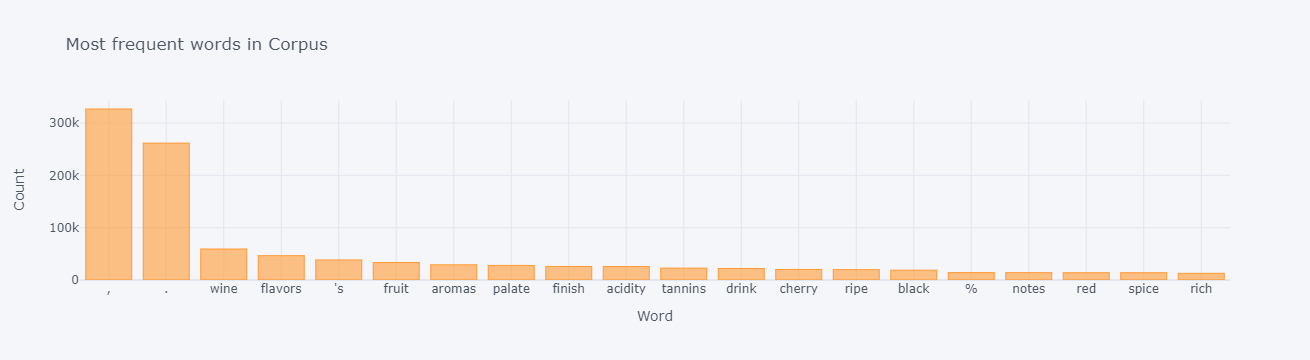

In [30]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [31]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3049749 words, 41331 unique words


In [32]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 13951


In [33]:
words_df = words_df[words_df.wordCount >= 4]

#### Bag of words (One-hot-encoding) for Train

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
clean_vocab = set(words_df.word)

In [36]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)

In [37]:
clean_bow_counts_train = count_vect.fit_transform(train_data.desc_low)
clean_bow_counts_train

<95990x13951 sparse matrix of type '<class 'numpy.int64'>'
	with 2534407 stored elements in Compressed Sparse Row format>

In [38]:
clean_bow_counts_train.shape

(95990, 13951)

#### Bag of words (One-hot-encoding) for Test

In [39]:
clean_bow_counts_test = count_vect.fit_transform(test_data.desc_low)
clean_bow_counts_test

<23998x13951 sparse matrix of type '<class 'numpy.int64'>'
	with 630017 stored elements in Compressed Sparse Row format>

In [40]:
clean_bow_counts_test.shape

(23998, 13951)

### Regression (not Classification)

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [42]:
from sklearn.linear_model import LinearRegression, Ridge

#### Search for the best alpha on the Train set only :

In [43]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts_train, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

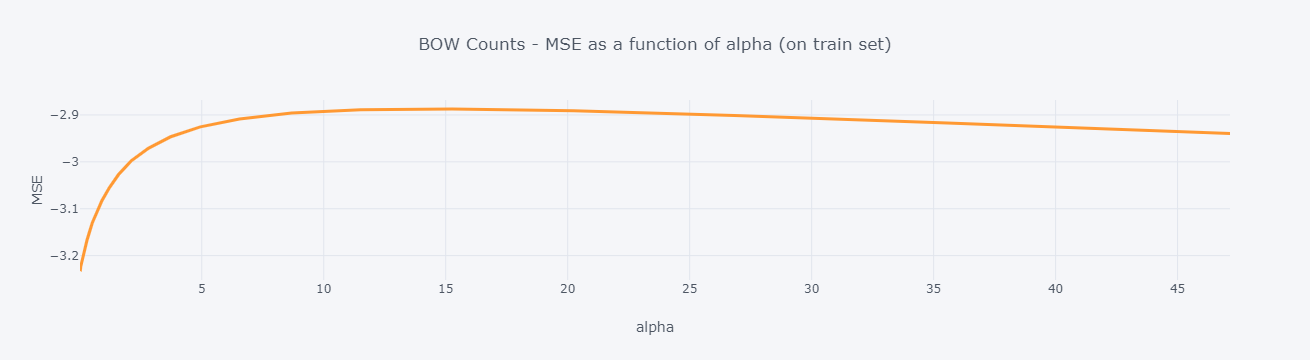

In [44]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [45]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.88740554174887


#### Optimal Model : training the model with the best alpha, on the train set:

In [46]:

model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [47]:
test_data['ridge_predicted_points'] = model.predict(clean_bow_counts_test)

In [48]:
ridge_stats = calc_prediction_quality(test_data, 'ridge_predicted_points','points')
ridge_stats

MSE    2.916858
MAE    1.347623
R2     0.694970
dtype: float64

In [49]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970


### Using both the text and other features

#### Using both the text and other features (encoded in the Boosting trees part)

In [50]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

In [51]:
from scipy.sparse import coo_matrix, hstack

In [52]:
train_features_spares_matrix = coo_matrix(train_encoded_features)
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

In [53]:
train_features_spares_matrix.shape

(95990, 9)

#### Search for the best alpha on the Train set only :

In [54]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

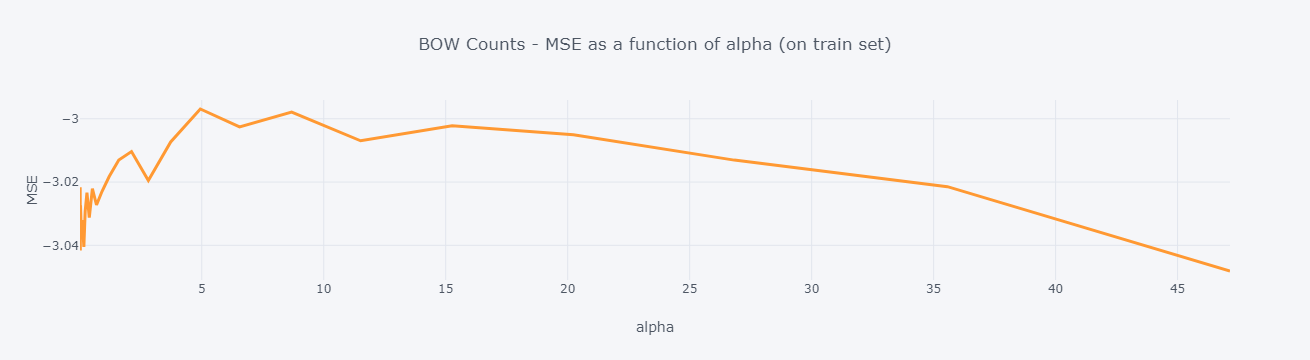

In [55]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [56]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

4.941713361323833 2.9969217712215714


#### Optimal Model : training the model with the best alpha, on the train set:

In [57]:
#
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=4.941713361323833)

In [58]:
test_data['ridge2_predicted_points'] = model.predict(clean_bow_counts_test)

In [59]:
ridge2_stats = calc_prediction_quality(test_data, 'ridge2_predicted_points','points')
ridge2_stats

MSE    2.952244
MAE    1.354847
R2     0.691269
dtype: float64

In [60]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970
ridge2_stats,2.952244,1.354847,0.691269


#### Are there outliars in the encoded features ?

country           AxesSubplot(0.125,0.657941;0.227941x0.222059)
province       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
region_1       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
region_2          AxesSubplot(0.125,0.391471;0.227941x0.222059)
taster_name    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
variety        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
winery               AxesSubplot(0.125,0.125;0.227941x0.222059)
price             AxesSubplot(0.398529,0.125;0.227941x0.222059)
points            AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

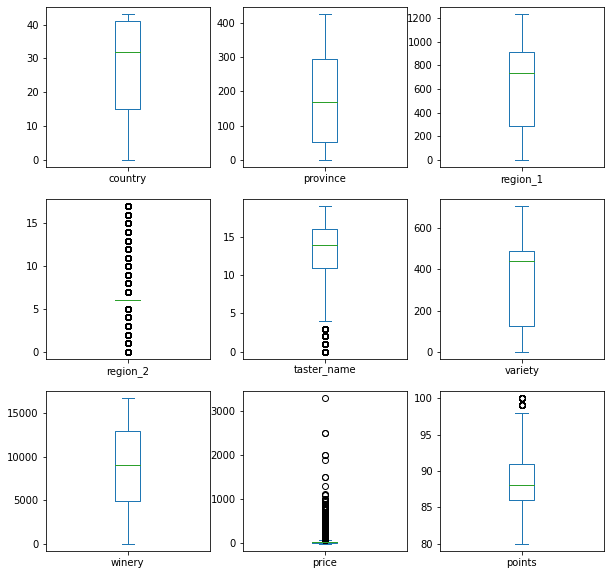

In [61]:
train_encoded_features.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

import numpy as np
from scipy import stats
train_encoded_features[(np.abs(stats.zscore(train_encoded_features)) < 3).all(axis=1)]


In [62]:
#removing the 'price' feature as it's showing a lot of outliars:
encoded_features2 = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features2['points'] = wine_reviews.points
encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87


In [63]:
encoded_features2.shape

(119988, 8)

In [64]:
# cols = ['taster_name'] # one or more

# Q1 = encoded_features2[cols].quantile(0.25)
# Q3 = encoded_features2[cols].quantile(0.75)
# IQR = Q3 - Q1

# encoded_features2 = encoded_features2[~((encoded_features2[cols] < (Q1 - 1.5 * IQR)) |(encoded_features2[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
# encoded_features2.shape

In [65]:
# encoded_features2.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

In [66]:
len(wine_reviews)

119988

In [67]:
train_encoded_features2 = encoded_features2[encoded_features2.index.isin(train_data.index)]
test_encoded_features2 = encoded_features2[encoded_features2.index.isin(test_data.index)]
assert(len(train_encoded_features2) + len(test_encoded_features2) == len(wine_reviews))

In [68]:
train_features_spares_matrix2 = coo_matrix(train_encoded_features2)
train_united_features2 = hstack((clean_bow_counts_train ,train_features_spares_matrix2))

In [69]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features2, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

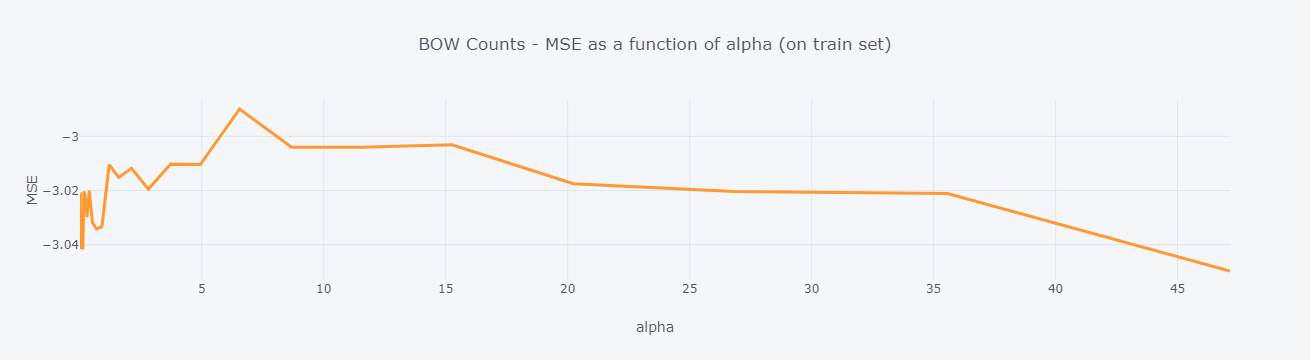

In [70]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [71]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

6.551285568595509 2.9898983627270486


In [72]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=6.551285568595509)

In [73]:
test_data['ridge3_predicted_points'] = model.predict(clean_bow_counts_test)

In [74]:
ridge3_stats = calc_prediction_quality(test_data, 'ridge3_predicted_points','points')
ridge3_stats

MSE    2.937491
MAE    1.351826
R2     0.692812
dtype: float64

In [75]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats, ridge3_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats', 'ridge3_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970
ridge2_stats,2.952244,1.354847,0.691269
ridge3_stats,2.937491,1.351826,0.692812


#### Tokenization

In [76]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [77]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [78]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [79]:
vectorize_layer.adapt(train_data['description'])

In [80]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

Pretty generic-tasting but basically good, a dry red wine with considerable tannins and acids that frame herbal cherry flavors.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([ 225,    1,   23, 3082,   72,    4,   42,   34,    9,    6,  987,
         24,    2,  358,   19,  762,  108,   26,   10,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [81]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

225 --->  pretty
1 --->  [UNK]
23 --->  but
3082 --->  basically
72 --->  good
4 --->  a
42 --->  dry
34 --->  red
9 --->  wine
6 --->  with
987 --->  considerable
24 --->  tannins
2 --->  and
358 --->  acids
19 --->  that
762 --->  frame
108 --->  herbal
26 --->  cherry
10 --->  flavors
0 --->  


# description only

#### Modeling

In [82]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

In [84]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [85]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [86]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 7s 8ms/step - loss: 22.3588 - mean_squared_error: 1392.8345 - mean_absolute_error: 22.3588 - val_loss: 2.4795 - val_mean_squared_error: 9.2627 - val_mean_absolute_error: 2.4795
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 3.4616 - mean_squared_error: 18.7920 - mean_absolute_error: 3.4616 - val_loss: 1.7251 - val_mean_squared_error: 4.6809 - val_mean_absolute_error: 1.7251
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1723 - mean_squared_error: 15.8169 - mean_absolute_error: 3.1723 - val_loss: 1.5208 - val_mean_squared_error: 3.6991 - val_mean_absolute_error: 1.5208
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1072 - mean_squared_error: 15.2173 - mean_absolute_error: 3.1072 - val_loss: 1.4721 - val_mean_squared_error: 3.4854 - val_mean_absolute_error: 1.4721
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 3.0724 - mean_

### Simple NN Prediction & Evaluation

In [87]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [88]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    3.002563
MAE    1.367198
R2     0.686007
dtype: float64

In [89]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats,ridge3_stats,dnn_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats','ridge3_stats', 'dnn_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970
ridge2_stats,2.952244,1.354847,0.691269
ridge3_stats,2.937491,1.351826,0.692812
dnn_prediction,3.002563,1.367198,0.686007


In [90]:
train_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
81189,US,"Inky dark, this is a combination of herb and c...",NaN,91,80.0,California,Mount Veeder,Napa,Virginie Boone,@vboone,VGS 2011 Cabernet Franc (Mount Veeder),Cabernet Franc,VGS,"inky dark, this is a combination of herb and c..."
23877,US,"Martella's Hammer Syrah, which is a statewide ...",Hammer,90,24.0,California,California,California Other,NaN,NaN,Martella 2006 Hammer Syrah (California),Syrah,Martella,"martella's hammer syrah, which is a statewide ..."
79331,France,This beautifully balanced wine shows rich red ...,NaN,89,18.0,Provence,Côtes de Provence,NaN,Roger Voss,@vossroger,Hecht & Bannier 2014 Rosé (Côtes de Provence),Rosé,Hecht & Bannier,this beautifully balanced wine shows rich red ...
15860,US,This wine shows a high degree of spiciness wit...,Lewis MacGregor Estate Vineyard,96,85.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Williams Selyem 2014 Lewis MacGregor Estate Vi...,Pinot Noir,Williams Selyem,this wine shows a high degree of spiciness wit...
76764,France,"A kind of zesty ripeness rises from the glass,...",Gloeckelberg Grand Cru,92,40.0,Alsace,Alsace,NaN,Anne Krebiehl MW,@AnneInVino,Domaine Fernand Engel 2015 Gloeckelberg Grand ...,Gewürztraminer,Domaine Fernand Engel,"a kind of zesty ripeness rises from the glass,..."


### Descriptions words concatinated

In [91]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [92]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [93]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [94]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [95]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 8s 9ms/step - loss: 24.3650 - mean_squared_error: 1110.5365 - mean_absolute_error: 24.3650 - val_loss: 2.6605 - val_mean_squared_error: 10.9944 - val_mean_absolute_error: 2.6605
Epoch 2/20
750/750 [==============================] - 7s 9ms/step - loss: 8.7418 - mean_squared_error: 119.6877 - mean_absolute_error: 8.7418 - val_loss: 2.6301 - val_mean_squared_error: 10.6489 - val_mean_absolute_error: 2.6301
Epoch 3/20
750/750 [==============================] - 7s 9ms/step - loss: 8.6764 - mean_squared_error: 117.9455 - mean_absolute_error: 8.6764 - val_loss: 2.6090 - val_mean_squared_error: 10.4363 - val_mean_absolute_error: 2.6090
Epoch 4/20
750/750 [==============================] - 7s 9ms/step - loss: 8.6943 - mean_squared_error: 118.4123 - mean_absolute_error: 8.6943 - val_loss: 2.6367 - val_mean_squared_error: 10.7231 - val_mean_absolute_error: 2.6367
Epoch 5/20
750/750 [==============================] - 7s 9ms/step - loss: 8.6310 

In [96]:
test_data['dnn2_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [97]:
train_data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
81189,US,"Inky dark, this is a combination of herb and c...",NaN,91,80.0,California,Mount Veeder,Napa,Virginie Boone,@vboone,VGS 2011 Cabernet Franc (Mount Veeder),Cabernet Franc,VGS,"inky dark, this is a combination of herb and c..."
23877,US,"Martella's Hammer Syrah, which is a statewide ...",Hammer,90,24.0,California,California,California Other,NaN,NaN,Martella 2006 Hammer Syrah (California),Syrah,Martella,"martella's hammer syrah, which is a statewide ..."
79331,France,This beautifully balanced wine shows rich red ...,NaN,89,18.0,Provence,Côtes de Provence,NaN,Roger Voss,@vossroger,Hecht & Bannier 2014 Rosé (Côtes de Provence),Rosé,Hecht & Bannier,this beautifully balanced wine shows rich red ...
15860,US,This wine shows a high degree of spiciness wit...,Lewis MacGregor Estate Vineyard,96,85.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Williams Selyem 2014 Lewis MacGregor Estate Vi...,Pinot Noir,Williams Selyem,this wine shows a high degree of spiciness wit...
76764,France,"A kind of zesty ripeness rises from the glass,...",Gloeckelberg Grand Cru,92,40.0,Alsace,Alsace,NaN,Anne Krebiehl MW,@AnneInVino,Domaine Fernand Engel 2015 Gloeckelberg Grand ...,Gewürztraminer,Domaine Fernand Engel,"a kind of zesty ripeness rises from the glass,..."


In [98]:
dnn2_stats = calc_prediction_quality(test_data, 'dnn2_prediction', target_col)
dnn2_stats

MSE    10.436271
MAE     2.608984
R2     -0.091373
dtype: float64

In [99]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats,ridge3_stats,dnn_stats, dnn2_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats','ridge3_stats', 'dnn_prediction', 'dnn2_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970
ridge2_stats,2.952244,1.354847,0.691269
ridge3_stats,2.937491,1.351826,0.692812
dnn_prediction,3.002563,1.367198,0.686007
dnn2_prediction,10.436271,2.608984,-0.091373


# LSTM

In [101]:
vocab_size = 32000
sequence_length = 60

vectorize_layer2 = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

vectorize_layer2.adapt(train_data['description'])

#### Modeling

In [102]:
from keras.layers import LSTM
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer2,
    Embedding(vocab_size, embedding_dim , input_length = sequence_length , name="embedding"),
    LSTM(32,activation="tanh",name='lstm_hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_hidden_layer (LSTM)    (None, 32)                6272      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 518,305
Trainable params: 518,305
Non-trainable params: 0
________________________________________________

In [103]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [104]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=32,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
3000/3000 [==============================] - 53s 17ms/step - loss: 34.3049 - mean_squared_error: 1802.3058 - mean_absolute_error: 34.3049 - val_loss: 2.6721 - val_mean_squared_error: 11.1458 - val_mean_absolute_error: 2.6721
Epoch 2/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.5986 - mean_squared_error: 68.5406 - mean_absolute_error: 6.5986 - val_loss: 2.6208 - val_mean_squared_error: 10.5554 - val_mean_absolute_error: 2.6208
Epoch 3/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.5278 - mean_squared_error: 67.3660 - mean_absolute_error: 6.5278 - val_loss: 2.5626 - val_mean_squared_error: 10.0145 - val_mean_absolute_error: 2.5626
Epoch 4/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.4504 - mean_squared_error: 65.7989 - mean_absolute_error: 6.4504 - val_loss: 2.5361 - val_mean_squared_error: 9.8125 - val_mean_absolute_error: 2.5361
Epoch 5/20
3000/3000 [==============================] - 50s 17ms/step

In [105]:
test_data['dnn3_lstm_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 4s 4ms/step


In [106]:
dnn3_lstm_prediction = calc_prediction_quality(test_data, 'dnn3_lstm_prediction', target_col)
dnn3_lstm_prediction

MSE    3.608612
MAE    1.501841
R2     0.622629
dtype: float64

In [107]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats,ridge3_stats,dnn_stats, dnn2_stats,dnn3_lstm_prediction], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats','ridge3_stats', 'dnn_prediction', 'dnn2_prediction','dnn3_lstm_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970
ridge2_stats,2.952244,1.354847,0.691269
ridge3_stats,2.937491,1.351826,0.692812
dnn_prediction,3.002563,1.367198,0.686007
dnn2_prediction,10.436271,2.608984,-0.091373
dnn3_lstm_prediction,3.608612,1.501841,0.622629


# Using external embedding (description feature only)

In [108]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras

path_to_glove_file = "D:/Users/1/Desktop/DS-Thechnion/Python_ML-2022/Final project/data/glove.6B.100d.txt"

In [109]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [110]:
num_tokens = len(vectorize_layer.get_vocabulary()) + 2
word_index = dict(zip(vectorize_layer.get_vocabulary(), range(len(vectorize_layer.get_vocabulary()))))

embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [111]:
model4 = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(num_tokens,embedding_dim, embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix), name="embedding" , trainable=False),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [112]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 100)           3200200   
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               16564     
                                                                 
 dropout_3 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [113]:
model4.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [114]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 18s 24ms/step - loss: 5.5262 - mean_squared_error: 48.3624 - mean_absolute_error: 5.5262 - val_loss: 1.5486 - val_mean_squared_error: 3.8423 - val_mean_absolute_error: 1.5486
Epoch 2/20
750/750 [==============================] - 17s 23ms/step - loss: 5.5306 - mean_squared_error: 48.2405 - mean_absolute_error: 5.5306 - val_loss: 1.7215 - val_mean_squared_error: 4.6461 - val_mean_absolute_error: 1.7215
Epoch 3/20
750/750 [==============================] - 18s 23ms/step - loss: 5.4704 - mean_squared_error: 47.3513 - mean_absolute_error: 5.4704 - val_loss: 1.6150 - val_mean_squared_error: 4.1291 - val_mean_absolute_error: 1.6150
CPU times: total: 2min 46s
Wall time: 53 s


In [115]:
test_data['External_Embedding'] = model.predict(test_data[text_col])

750/750 [==============================] - 4s 5ms/step


In [116]:
External_Embedding = calc_prediction_quality(test_data, 'External_Embedding', target_col)
External_Embedding

MSE    3.842250
MAE    1.548594
R2     0.598197
dtype: float64

In [117]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats,ridge3_stats,dnn_stats, dnn2_stats,dnn3_lstm_prediction,External_Embedding], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats','ridge3_stats', 'dnn_prediction', 'dnn2_prediction','dnn3_lstm_prediction','External_Embedding'])
all_compared

,MSE,MAE,R2
baseline_1,9.563000,2.537501,-0.000050
baseline_2,9.074026,2.468089,0.051084
baseline_3,8.521907,2.375824,0.108822
ridge_stats,2.916858,1.347623,0.694970
ridge2_stats,2.952244,1.354847,0.691269
ridge3_stats,2.937491,1.351826,0.692812
dnn_prediction,3.002563,1.367198,0.686007
dnn2_prediction,10.436271,2.608984,-0.091373
dnn3_lstm_prediction,3.608612,1.501841,0.622629
External_Embedding,3.842250,1.548594,0.598197
